In [2]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
"""
Copyright (C) 2022 LAAS-CNRS, INRIA

Author:
    Wilson Jallet
"""

import proxsuite_nlp

import pinocchio as pin

from darli.backend import CasadiBackend
from darli.modeling.functional import Functional
from varitop.integrator import DelIntegrator as DI
from varitop.misc import euler_rule, skew_quaternion, qconj, q2rm

import numpy as np
import casadi as cas

import example_robot_data as erd
import matplotlib.pyplot as plt

from proxsuite_nlp.manifolds import MultibodyPhaseSpace, VectorSpace
from proxsuite_nlp.utils import plot_pd_errs
from proxsuite_nlp.casadi_utils import CasadiFunction

In [4]:
urdf_path = "../assets/urdf/skydio_x2.urdf"

In [5]:
print("Package version: {}".format(proxsuite_nlp.__version__))
# robot = erd.load("double_pendulum")
model = pin.buildModelFromUrdf(urdf_path)
rdata = model.createData()

Package version: 0.4.0


In [6]:
darli_model = Functional(CasadiBackend(urdf_path))
darli_model.nq, darli_model.nv, darli_model.nu

(7, 6, 6)

In [8]:
Tf = 1.2
dt = 1.0 / 30
nsteps = int(Tf / dt)
Tf = nsteps * dt
print("Time horizon: {:.3g}".format(Tf))
print("Time step   : {:.3g}".format(dt))
print("No. of steps: {:d}".format(nsteps))

nq = model.nq
B = np.array([[0.0], [1.0]])
nu = B.shape[1]

Time horizon: 1.2
Time step   : 0.00333
No. of steps: 359


In [10]:
xspace = MultibodyPhaseSpace(model)
pb_space = VectorSpace(nsteps * nu + (nsteps + 1) * (xspace.nx))

u_bound = 0.25
x0 = xspace.neutral()
theta0 = np.pi / 3
x0[3] = np.sin(theta0 / 2)
x0[6] = np.cos(theta0 / 2)
xtarget = xspace.neutral()
print("Initial:", x0)
print("Final  :", xtarget)

Initial: [0.        0.        0.        0.8660254 0.5       0.        1.
 0.        0.        0.        0.        0.        0.       ]
Final  : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [19]:
def make_dynamics_expression(x0, cxs, cus):
    resdls = [cxs[0] - x0, cxs[1] - x0]

    for t in range(2, nsteps):
        x0 = cxs[t - 2][:nq]
        x1 = cxs[t - 1][:nq]
        x2 = cxs[t - 0][:nq]
        v2 = cxs[t - 0][nq:]
        u2 = cus[t - 0]

        K = cas.vcat(
            [
                cas.hcat([-0.18, 0.18, 0.18, -0.18]),
                cas.hcat([0.14, 0.14, -0.14, -0.14]),
                cas.hcat([-0.0201, 0.0201, 0.0201, -0.0201]),
            ]
        )

        di = DI()
        di.nq = darli_model.nq
        di.nu = darli_model.nu
        di.quaternion_index = 3
        cq = cas.SX.sym("cq", darli_model.nq)
        cdq = cas.SX.sym("cdq", darli_model.nq)
        cu = cas.SX.sym("cu", darli_model.nu)
        F = cas.Function(
            "f",
            [cq, cdq, cu],
            [
                cas.vcat(
                    [0, 0, 0, 2 * skew_quaternion(cq[3:]) @ cas.vertcat(0, K @ cu[2:])]
                )
            ],
        )
        di.lagrangian = cas.Function(
            "L", [cq, cdq], [darli_model.lagrangian(cq, cdq)], ["q", "dq"], ["L"]
        )
        di.rule = euler_rule
        di.add_generalized_forces([F])

        qnext = di.get_residual()(q0, q1, q2, dt, u2)
        _, vnext = euler_rule(q1, q2, dt)  # Constraining velocities
        xnext = cas.vertcat(qnext, vnext)
        resdls.append(cxs[t - 0] - xnext)

        # print(qnext)

        # tau = B @ cus[t]
        # acc = cpin.aba(cmodel, cdata, q, v, tau)
        # vnext = v + dt * acc
        # qnext = cpin.integrate(cmodel, q, dt * vnext)
        # xnext = cas.vertcat(qnext, vnext)
        # resdls.append(cxs[t + 1] - xnext)
    expression = cas.vertcat(*resdls)
    return expression

In [20]:
class MultipleShootingProblem:
    """Multiple-shooting formulation."""

    def __init__(self, x0, xtarget):

        cxs = [cas.SX.sym("x%i" % i, xspace.nx) for i in range(nsteps + 1)]
        cus = [cas.SX.sym("u%i" % i, nu) for i in range(nsteps)]

        cX_s = cas.vertcat(*cxs)
        cU_s = cas.vertcat(*cus)
        cXU_s = cas.vertcat(cX_s, cU_s)

        w_u = 1e-2
        w_x = 1e-3
        w_term = 2.0 * np.ones(xspace.ndx)
        w_term[2:] = 1e-3
        ferr = cxs[nsteps] - xtarget
        cost_expression = (
            0.5 * w_x * dt * cas.dot(cX_s, cX_s)
            + 0.5 * w_u * dt * cas.dot(cU_s, cU_s)
            + 0.5 * cas.dot(ferr, w_term * ferr)
        )

        # Most probably can leave as is
        self.cost_fun = CasadiFunction(
            pb_space.nx, pb_space.ndx, cost_expression, cXU_s, use_hessian=True
        )

        x0 = cas.SX(x0)
        expression = make_dynamics_expression(x0, cxs, cus)
        self.dynamics_fun = CasadiFunction(
            pb_space.nx, pb_space.ndx, expression, cXU_s, use_hessian=False
        )

        # Most probably can leave as is
        control_bounds_ = []
        for t in range(nsteps):
            control_bounds_.append(cus[t] - u_bound)
            control_bounds_.append(-cus[t] - u_bound)
        control_expr = cas.vertcat(*control_bounds_)
        self.control_bound_fun = CasadiFunction(
            pb_space.nx, pb_space.ndx, control_expr, cXU_s, use_hessian=False
        )

In [21]:
probdef = MultipleShootingProblem(x0, xtarget)

cost_fun = proxsuite_nlp.costs.CostFromFunction(probdef.cost_fun)

dynamical_constraint = proxsuite_nlp.constraints.createEqualityConstraint(
    probdef.dynamics_fun
)

bound_constraint = proxsuite_nlp.constraints.createInequalityConstraint(
    probdef.control_bound_fun
)

constraints_ = []
constraints_.append(dynamical_constraint)
constraints_.append(bound_constraint)
problem = proxsuite_nlp.Problem(pb_space, cost_fun, constraints_)

print("No. of variables  :", pb_space.nx)
print("No. of constraints:", problem.total_constraint_dim)

callback = proxsuite_nlp.helpers.HistoryCallback()

No. of variables  : 1799
No. of constraints: 2154


In [22]:
tol = 1e-5
rho_init = 1e-8
mu_init = 0.9
solver = proxsuite_nlp.ProxNLPSolver(
    problem, mu_init=mu_init, rho_init=rho_init, tol=tol, verbose=proxsuite_nlp.VERBOSE
)
solver.setup()
solver.register_callback(callback)
solver.max_iters = 300

xu_init = pb_space.neutral()
for t in range(nsteps + 1):
    xu_init[t * xspace.nx] = theta0
lams0 = [np.zeros(cs.nr) for cs in constraints_]
try:
    flag = solver.solve(xu_init, lams0)
except RuntimeError:
    import pprint

    pprint.pp(callback.storage.xs.tolist())
    raise

workspace = solver.getWorkspace()
results = solver.getResults()

print(results)

iter｜step_size ｜inner_crit｜ prim_err ｜ dual_err ｜   xreg   ｜  dphi0   ｜  merit   ｜    dM    ｜ al_iter  
   1｜ 1.000e+00｜ 6.283e+00｜ 3.142e+00｜ 6.283e+00｜ 0.000e+00｜-7.848e+03｜ 1.008e+03｜ -2.92e+03｜         1
   2｜ 1.000e+00｜ 1.458e+01｜ 1.458e+01｜ 5.194e-02｜ 0.000e+00｜-2.015e+03｜ 7.758e-01｜ -1.01e+03｜         1
   3｜ 1.000e+00｜ 2.778e-01｜ 2.778e-01｜ 2.476e-02｜ 0.000e+00｜-5.041e-01｜ 1.027e+00｜    -0.228｜        13
   4｜ 1.000e+00｜ 1.325e-01｜ 1.325e-01｜ 1.362e-02｜ 0.000e+00｜-7.234e-02｜ 1.073e+00｜   -0.0354｜        20
   5｜ 1.000e+00｜ 2.591e-02｜ 2.591e-02｜ 4.076e-03｜ 0.000e+00｜-4.917e-03｜ 1.097e+00｜  -0.00245｜        35
   6｜ 1.000e+00｜ 1.110e-02｜ 1.110e-02｜ 1.985e-03｜ 0.000e+00｜-6.532e-04｜ 1.107e+00｜ -0.000327｜        43
   7｜ 1.000e+00｜ 5.034e-03｜ 5.034e-03｜ 9.616e-04｜ 0.000e+00｜-1.287e-04｜ 1.111e+00｜ -6.46e-05｜        51
   8｜ 5.000e-01｜ 2.258e-03｜ 2.258e-03｜ 5.123e-04｜ 0.000e+00｜-2.621e-05｜ 1.113e+00｜ -5.26e-06｜        58
   9｜ 1.000e+00｜ 2.032e-03｜ 2.032e-03｜ 3.785e-04｜ 0.000e+00｜-2.3

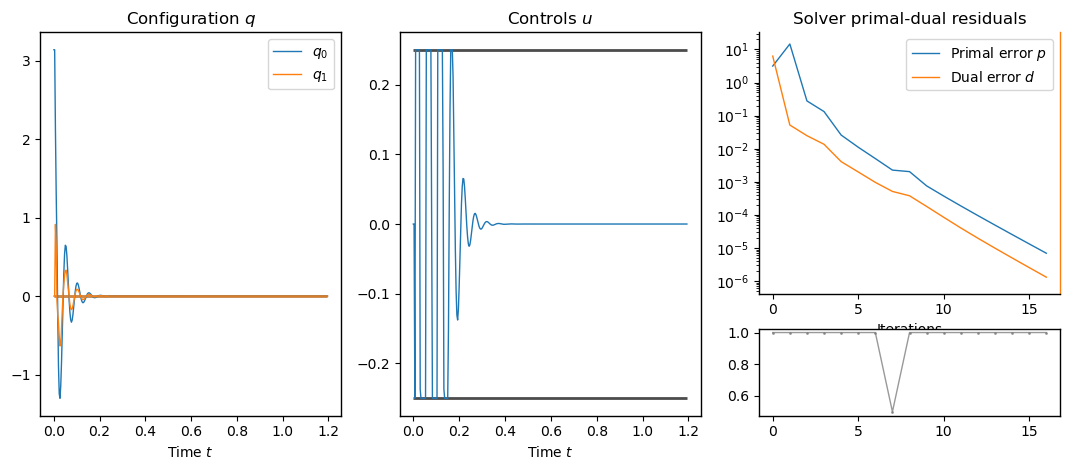

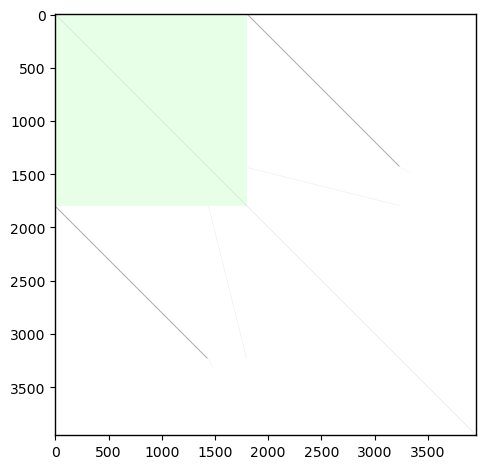

In [23]:
prim_errs = callback.storage.prim_infeas
dual_errs = callback.storage.dual_infeas

xus_opt = results.xopt
xs_opt_flat = xus_opt[: (nsteps + 1) * xspace.nx]
us_opt_flat = xus_opt[(nsteps + 1) * xspace.nx :]
us_opt = us_opt_flat.reshape(nsteps, -1)
xs_opt = xs_opt_flat.reshape(nsteps + 1, -1)
qs_opt = xs_opt[:, : model.nq]
vs_opt = xs_opt[:, model.nq :]

# Plotting

plt.rcParams["lines.linewidth"] = 1.0
plt.rcParams["axes.linewidth"] = 1.0

times = np.linspace(0.0, Tf, nsteps + 1)
labels_ = ["$x_{%i}$" % i for i in range(model.nq)]

fig: plt.Figure = plt.figure(figsize=(10.8, 4.8))
gs0 = fig.add_gridspec(1, 3)

plt.subplot(gs0[0])
hlines_style = dict(alpha=0.7, ls="-", lw=2, zorder=-1)
lines = plt.plot(times, qs_opt)
cols_ = [li.get_color() for li in lines]
labels_ = ["$q_{0}$".format(i) for i in range(model.nq)]
hlines = plt.hlines(xtarget[: model.nq], *times[[0, -1]], colors=cols_, **hlines_style)

plt.legend(labels_)
plt.xlabel("Time $t$")
plt.title("Configuration $q$")

plt.subplot(gs0[1])
plt.plot(times[:-1], us_opt)
plt.hlines((-u_bound, u_bound), *times[[0, -2]], colors="k", **hlines_style)
plt.xlabel("Time $t$")
plt.title("Controls $u$")

gss = gs0[2].subgridspec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gss[0])
plot_pd_errs(ax0, prim_errs, dual_errs)

plt.subplot(gss[1])
plt.plot(callback.storage.alphas, c="gray", alpha=0.8, marker=".", markersize=2)
plt.tight_layout()

# plot kkt matrix
fig, ax = plt.subplots()
kkt_mat = workspace.kkt_matrix.copy()
plt.imshow(kkt_mat.astype(bool), cmap=plt.cm.binary, vmin=0.0)
ntot = pb_space.ndx
ptch = plt.Rectangle((0, 0), ntot, ntot)
ptch.set_facecolor("#19ff1d")
ptch.set_alpha(0.1)
ptch.set_edgecolor("none")
ptch.set_transform(ax.transData)
ax.add_patch(ptch)

plt.tight_layout()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


/tmp/ipykernel_89071/1098454244.py:30: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point1.set_data(p1[0], p1[1])
/tmp/ipykernel_89071/1098454244.py:31: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point2.set_data(p2[0], p2[1])


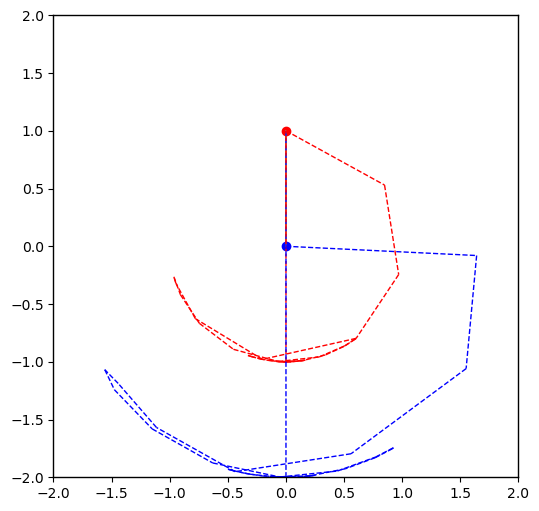

In [32]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# Create the two points
p1_prev = [np.sin(xs_opt[0, 0]), -np.cos(xs_opt[0, 0])]
p2_prev = p1_prev + [np.sin(xs_opt[0, 1]), -np.cos(xs_opt[0, 1])]
point1 = ax.plot(0, 0, "ro")[0]
point2 = ax.plot(0, 0, "bo")[0]
line1 = ax.plot([0, 0], [0, 0])[0]
line2 = ax.plot([0, 0], [0, 0])[0]


def update(frame):
    # Update the data of the first point

    global p1_prev, p2_prev

    phi0 = xs_opt[frame, 0]
    phi1 = xs_opt[frame, 1]

    p1 = [np.sin(phi0), -np.cos(phi0)]
    p2 = [p1[0] + np.sin(phi1), p1[1] - np.cos(phi1)]

    point1.set_data(p1[0], p1[1])
    point2.set_data(p2[0], p2[1])

    line1.set_data([0, p1[0]], [0, p1[1]])
    line2.set_data([p1[0], p2[0]], [p1[1], p2[1]])

    # ax.plot([p1_prev[0], p1[0]], [p1_prev[1], p1[1]], 'r--')
    # ax.plot([p2_prev[0], p2[0]], [p2_prev[1], p2[1]], 'b--')

    # p1_prev = p1
    # p2_prev = p2


# Create the animation
animation = FuncAnimation(fig, update, frames=len(xs_opt))

# Save the animation as a GIF using Pillow writer
animation.save("double_pendulum.gif")